In [1]:
%matplotlib notebook
%config InlineBackend.figure_format = 'retina'

# native
import sys
import os

# modules
from utils import *
from dataset import *
from vgg19min import *
from plotgrid import PlotGrid
from score import *
from trainer import *
from logger import *

# math
import numpy as np

# extra
from tqdm import tqdm
import logging

# pytorch
import torch
from torch.utils.data import DataLoader
from torch.utils import model_zoo

import torchvision
import torchvision.transforms as transforms


In [2]:
requirements = {
    torch: '1'
}

check_requirements(requirements)

In [3]:
cuda = torch.cuda.is_available()

if cuda:
    torch.backends.cudnn.benchmark = True
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

device = 'cuda' if cuda else 'cpu'

device

'cuda'

In [4]:
toPILImage = transforms.ToPILImage()

softmax = torch.nn.Softmax(dim=1)


In [5]:
ROOT_PATH = pathJoin(os.sep, 'var', 'node433', 'local', 'gulfaraz')

In [6]:
TRAIN_BATCH_SIZE = 8
TEST_BATCH_SIZE = 8
IMAGE_SIZE = (224, 224)

imagenet_normalization_values = {
    'mean': [0.485, 0.456, 0.406],
    'std': [0.229, 0.224, 0.225]
}

normalize = transforms.Normalize(**imagenet_normalization_values)
denormalize = DeNormalize(**imagenet_normalization_values)


def toImage(tensor_image):
    return toPILImage(denormalize(tensor_image))

raw_transforms = transforms.Compose([
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor()
])

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE[0]),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    normalize
])

miniimagenet_dataset_path = os.path.join(ROOT_PATH, 'datasets', 'miniimagenet')

original_train_dataset = MiniImageNetDataset(miniimagenet_dataset_path, transforms=train_transforms)#raw_transforms)
original_val_dataset = MiniImageNetDataset(miniimagenet_dataset_path, split='val', transforms=test_transforms)

original_train_loader = DataLoader(original_train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=8)
original_val_loader = DataLoader(original_val_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False, num_workers=8)

stylized_miniimagenet_dataset_path = os.path.join(ROOT_PATH, 'datasets', 'stylized-miniimagenet-1.0')

stylized_train_dataset = MiniImageNetDataset(stylized_miniimagenet_dataset_path, transforms=train_transforms)#raw_transforms)
stylized_val_dataset = MiniImageNetDataset(stylized_miniimagenet_dataset_path, split='val', transforms=test_transforms)

stylized_train_loader = DataLoader(stylized_train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=8)
stylized_val_loader = DataLoader(stylized_val_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False, num_workers=8)

for dataset, loader in [
    (original_train_dataset, original_train_loader),
    (original_val_dataset, original_val_loader),
    (stylized_train_dataset, stylized_train_loader),
    (stylized_val_dataset, stylized_val_loader)
]:
    print('{} Datapoints in {} Batches'.format(len(dataset), len(loader)))

100%|██████████| 10000/10000 [00:00<00:00, 26864.80it/s]

100000 Datapoints in 12500 Batches
10000 Datapoints in 1250 Batches
100000 Datapoints in 12500 Batches
10000 Datapoints in 1250 Batches


<IPython.core.display.Javascript object>


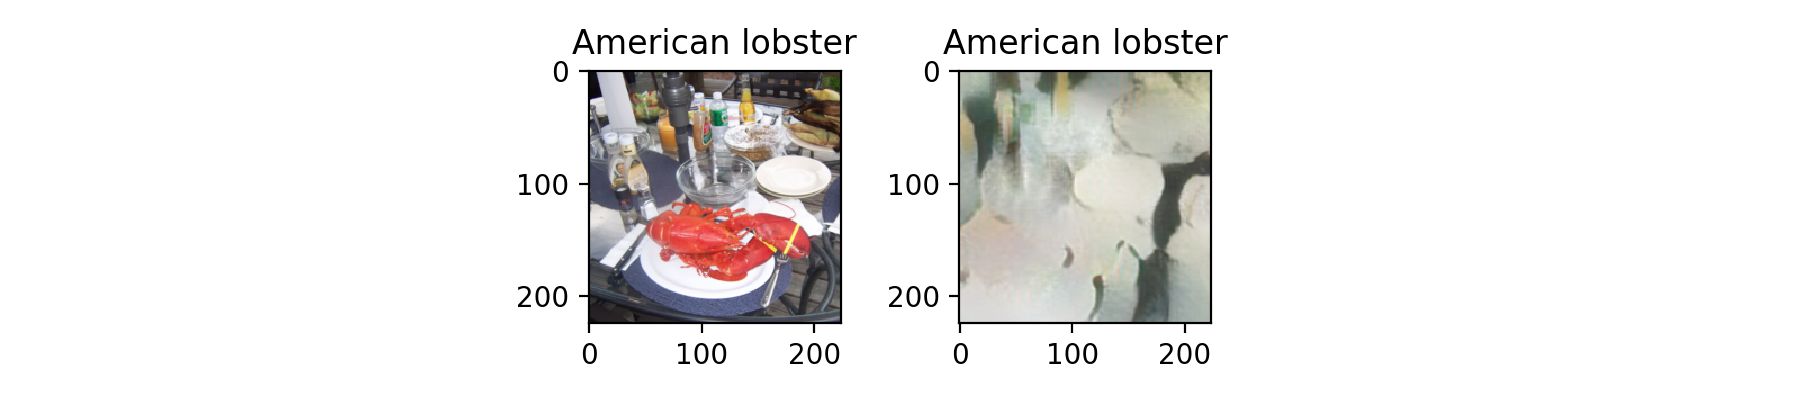

In [7]:
image_grid = PlotGrid(figsize=(9,2))

In [8]:
for index, image in enumerate(original_train_dataset):
    index_image = original_train_dataset.INDEX_IMAGE
    index_label = original_train_dataset.INDEX_LABEL
    
    # get datapoints
    original = original_train_dataset[index]
    stylized = stylized_train_dataset[index]
    
    # get images
    img = original[index_image]
    stylized_img = stylized[index_image]
    
    # plot images
    image_grid.plot((1, 2, 1), toImage(img), title=original[index_label])
    image_grid.plot((1, 2, 2), toImage(stylized_img), title=stylized[index_label])
    if (index + 1) == 9:
        break


In [ ]:
def create_logger(log_directory, filename, stream=False):
    info_filehandler = logging.FileHandler(os.path.join(log_directory, '{}_info.log'.format(filename)))
    debug_filehandler = logging.FileHandler(os.path.join(log_directory, '{}_debug.log'.format(filename)))

    formatter = logging.Formatter('%(asctime)s %(name)s %(levelname)s %(message)s')
    info_filehandler.setFormatter(formatter)
    debug_filehandler.setFormatter(formatter)

    info_filehandler.setLevel(logging.INFO)
    debug_filehandler.setLevel(logging.DEBUG)

    logger = logging.getLogger()
    for hdlr in logger.handlers[:]:
        logger.removeHandler(hdlr)

    if stream:
        streamhandler = logging.StreamHandler(sys.stdout)
        streamhandler.setFormatter(formatter)
        streamhandler.setLevel(logging.DEBUG)
        logger.addHandler(streamhandler)

    logger.addHandler(info_filehandler)
    logger.addHandler(debug_filehandler)

    logger.setLevel(logging.DEBUG)

    logging.getLogger('PIL.PngImagePlugin').setLevel(logging.ERROR)

    return logger


In [ ]:
supported_models = {
#     'vgg19_in_pretrained_in_tuned_min': create_vgg19_in_pretrained,
#     'vgg19_in_batch_stats_pretrained_in_tuned_min': create_vgg19_in_pretrained, # create_vgg19_in_batch_stats_pretrained / create_vgg19_in_bs_eval / create_vgg19_in_pretrained
#     'vgg19_pretrained_in_tuned_min': create_vgg19_pretrained,
#     'vgg19_scratch_min': create_vgg19_scratch,
#     'vgg19_bn_pretrained_in_tuned_min': create_vgg19_bn_all_tune_fc,
#     'vgg19_in_single_tune_all_2': create_vgg19_in_single_tune_all,
#     'vgg19_in_bs_single_tune_all': create_vgg19_in_bs_single_tune_all,
#     'vgg19_in_all_tune_all': create_vgg19_in_all_tune_all,
#     'vgg19_in_bs_all_tune_all': create_vgg19_in_bs_all_tune_all
#     'vgg19_in_affine_single_tune_all': create_vgg19_in_affine_single_tune_all,
#     'vgg19_bn_all_tune_all': create_vgg19_bn_all_tune_all,
    'vgg19_bn_single_in_tune_all': create_vgg19_bn_single_in_tune_all
}

for model_type in supported_models:
    print(model_type)
    model = supported_models[model_type]()
#     print(model)
    for batch in original_train_loader:
        index_image = original_train_loader.dataset.INDEX_IMAGE
        model(batch[index_image].to(device))
        break
    del model
    torch.cuda.empty_cache()


In [ ]:
training = True
epochs = 50
monitor = False


# setup log directory
log_directory = pathJoin('run_logs')
os.makedirs(log_directory, exist_ok=True)

for model_type in supported_models:

    # original
    run_name = '{}'.format(model_type)
    logger = create_logger(log_directory, run_name)
    logger.info('Run Name {}'.format(run_name))
    model = supported_models[model_type]()
    run(run_name, model, training, epochs, monitor, logger, original_train_loader, original_val_loader)

#     # stylized
#     run_name = 'stylized_{}'.format(model_type)
#     logger = create_logger(log_directory, run_name)
#     logger.info('Run Name {}'.format(run_name))
#     model = supported_models[model_type]()
#     run(run_name, model, training, epochs, monitor, logger, stylized_train_loader, stylized_val_loader)

    del model
    torch.cuda.empty_cache()


In [ ]:
# def find_normalization_values(dataset, image_index):
#     loader = DataLoader(dataset, batch_size=len(dataset), shuffle=True)
#     all_images = None
#     for i in loader:
#         all_images = i[image_index]
#     mean_image = all_images.mean(0)
#     std_image = all_images.std(0)
#     mean = mean_image.view(mean_image.size(0), -1).mean(-1)
#     std = std_image.view(std_image.size(0), -1).mean(-1)
#     return {
#         'mean': mean.numpy().tolist(),
#         'std': std.numpy().tolist()
#     }

# find_normalization_values(miniimagenet_train_dataset, 1)
# find_normalization_values(stylized_miniimagenet_train_dataset, 1)

## Check Performance

In [ ]:
for model_type in supported_models:
    print(model_type)
    model = supported_models[model_type]()
    
#     checkpoint = {
#         'epoch': epoch,
#         'train_accuracy': train_accuracy,
#         'train_loss': train_loss,
#         'validation_accuracy': validation_accuracy,
#         'weights': model.state_dict()
#     }
    checkpoint_path = pathJoin(ROOT_PATH, 'models', '{}.ckpt'.format(model_type))
#     checkpoint_path = pathJoin('trained_models', 'min', 'stylized_{}.ckpt'.format(model_type))
    print(checkpoint_path)
    
    if os.path.isfile(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)

        epoch = checkpoint['epoch']
        train_top1_accuracy = checkpoint['train_top1_accuracy']
        train_top5_accuracy = checkpoint['train_top5_accuracy']
        train_loss = checkpoint['train_loss']
        validation_top1_accuracy = checkpoint['validation_top1_accuracy']
        validation_top5_accuracy = checkpoint['validation_top5_accuracy']
        validation_loss = checkpoint['validation_loss']
        model.load_state_dict(checkpoint['weights'])

        model.eval()

        original_top1, original_top5 = score_model(model, original_val_loader)
        stylized_top1, stylized_top5 = score_model(model, stylized_val_loader)
        print('Original: Epoch: {} Top1: {:.4f} Top5: {:.4f}'.format(epoch, original_top1, original_top5))
        print('Stylized: Epoch: {} Top1: {:.4f} Top5: {:.4f}'.format(epoch, stylized_top1, stylized_top5))
        print('Train: Loss: {:.4f} Top1 Accuracy: {:.4f} Top5 Accuracy: {:.4f}'.format(train_loss, train_top1_accuracy, train_top5_accuracy))
        print('Validation: Loss: {:.4f} Top1 Accuracy: {:.4f} Top5 Accuracy: {:.4f}'.format(validation_loss, validation_top1_accuracy, validation_top5_accuracy))
    else:
        print('Checkpoint not available for model {}'.format(model_type))
    del model
    torch.cuda.empty_cache()
